In [71]:
import os
import csv
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    cross_val_score,
    cross_val_predict
)

In [67]:
def get_region_list(base_path):
    return sorted([
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
           and not d.startswith('all_models')
           and not d.startswith('hcp')
           and not d.startswith('ukb')
           and not d.endswith('.csv')
           and not d.endswith('.sh')
           and not d.endswith('embeddings')
    ])

In [72]:
# CONFIG
labels_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/cognition/nc_y_nihtb.csv"
base_path   = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/embeddings/ABCD_embeddings/"

scores = [
 'nihtbx_flanker_agecorrected',
 'nihtbx_cardsort_agecorrected',
 'nihtbx_list_agecorrected',
 'nihtbx_pattern_agecorrected',
 'nihtbx_picvocab_agecorrected',
 'nihtbx_reading_agecorrected',
 'nihtbx_fluidcomp_agecorrected',
 'nihtbx_cryst_agecorrected',
 'nihtbx_totalcomp_agecorrected'
]

labels_df = pd.read_csv(labels_path)
print(labels_df.shape)
labels_df = labels_df[labels_df["eventname"] == "baseline_year_1_arm_1"]
print(labels_df.shape)

existing_scores = [s for s in scores if s in labels_df.columns]
cols = ["src_subject_id"] + existing_scores
labels_df = labels_df[cols]
print(labels_df.index)

regions = get_region_list(os.path.join(base_path,"../.."))
regions.remove("params_OLS")
regions.remove("region_list")
regions.remove("analysis")
#regions = ["STs_right","FCLp-subsc-FCLa-INSULA_right","FCMpost-SpC_right","STi-STs-STpol_right"]
#region = regions[0]

labels_df['src_subject_id'] = (
    labels_df['src_subject_id'].astype(str)
    .str.replace(r"^sub-", "", regex=True)
    .str.replace("_", "", regex=False)
)

df_ages = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/prematurity_labels_true_classes.csv")
df_ages = df_ages[df_ages["prem_class"].isin(["<28","28-32", "32-37", ">=37"])]


(27028, 120)
(11727, 120)
Index([    0,     1,     3,     5,     7,    10,    13,    15,    18,    20,
       ...
       27001, 27003, 27006, 27008, 27010, 27012, 27015, 27018, 27021, 27024],
      dtype='int64', length=11727)


/tmp/ipykernel_692329/2559302001.py:17: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  labels_df = pd.read_csv(labels_path)


In [69]:
def preprocess_data(df):
    
    df_with_cognition_and_ages= df.merge(
        labels_df,
        left_on='src_subject_id', right_on='src_subject_id', how='inner'
    )

    return df_with_cognition_and_ages

df = preprocess_data(df_ages)
df.to_csv(
    "df_with_cognition_and_ages.csv",
    index=False
)

In [129]:
from scipy.stats import pearsonr, ttest_ind,spearmanr

# CONFIG
data_csv = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/df_with_cognition_and_ages.csv"  
ga_col = "gest_age"        
prem_binary_col = "devhx_12a_p"  # 1 = préma, 0 = terme
out_csv = "prematurity_stats_simple.csv"

df = pd.read_csv(data_csv)
df[prem_binary_col] = df[prem_binary_col].astype(int)
print("Loaded:", df.shape)

#Cohen's d
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mx, my = np.mean(x), np.mean(y)
    sx2, sy2 = np.var(x, ddof=1), np.var(y, ddof=1)
    pooled = np.sqrt(((nx-1)*sx2 + (ny-1)*sy2) / (nx+ny-2)) if (nx+ny-2)>0 else np.nan
    if pooled == 0 or np.isnan(pooled):
        return np.nan
    return (mx - my) / pooled

rows = []
for score in scores:
    r_row = {'score': score}

    # Pearson correlation GA -score
    sub_pre = df[df["prem_class"].isin(["28-32"])][[score, ga_col]].dropna()
    if sub_pre.shape[0] >= 4:
        r_pre, p_pre = pearsonr(sub_pre[ga_col], sub_pre[score])
        r_spear, p_spear = spearmanr(sub_pre[ga_col], sub_pre[score])
    else:
        r_pre, p_pre = np.nan, np.nan
    r_row['pearson_r_ga_pre'] = r_pre
    r_row['pearson_p_ga_pre'] = p_pre
    r_row['n_pre_corr'] = len(sub_pre)
    r_row['spearman_r_ga_pre'] = r_spear
    r_row['spearman_p_ga_pre'] = p_spear

    # pearson on small preterms
    sub_smallpreterm = df[df["prem_class"].isin(["32-37"])][[score, ga_col]].dropna()
    if sub_smallpreterm.shape[0] >= 4:
        r_term, p_term = pearsonr(sub_smallpreterm[ga_col], sub_smallpreterm[score])
        r_spear_term, p_spear_term = spearmanr(sub_smallpreterm[ga_col], sub_smallpreterm[score])
    else:
        r_term, p_term = np.nan, np.nan
    r_row['pearson_r_ga_smallpre'] = r_term
    r_row['pearson_p_ga_smallpre'] = p_term
    r_row['n_smallpre_corr'] = len(sub_smallpreterm)
    r_row['spearman_r_ga_smallpre'] = r_spear_term
    r_row['spearman_p_ga_smallpre'] = p_spear_term

    # Welch t-test preterms vs terms
    sub_t = df[[score, prem_binary_col]].dropna()
    grp_pre  = sub_t[sub_t[prem_binary_col] == 1][score].values
    grp_term = sub_t[sub_t[prem_binary_col] == 0][score].values
    r_row['n_pre']  = len(grp_pre)
    r_row['n_term'] = len(grp_term)

    if len(grp_pre) >= 3 and len(grp_term) >= 3:
        t_stat, p_t = ttest_ind(grp_pre, grp_term, equal_var=False, nan_policy='omit')
        d = cohen_d(grp_pre, grp_term)
    else:
        t_stat, p_t, d = np.nan, np.nan, np.nan

    r_row['t_stat_pre_vs_term'] = t_stat
    r_row['p_t_pre_vs_term'] = p_t
    r_row['cohen_d_pre_vs_term'] = d

    rows.append(r_row)

res_df = pd.DataFrame(rows)
#res_df.to_csv(out_csv, index=False)
print("Saved summary to", out_csv)


Loaded: (9856, 14)
Saved summary to prematurity_stats_simple.csv


/tmp/ipykernel_692329/998420952.py:9: DtypeWarning: Columns (307,338,352,385,397,405,436,443) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sex = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/all_labels_clean_abcd_new_classes.csv")[["src_subject_id_clean","demo_sex_v2"]]


Index(['src_subject_id', 'devhx_12a_p', 'devhx_12_p', 'gest_age', 'prem_class',
       'nihtbx_flanker_agecorrected', 'nihtbx_cardsort_agecorrected',
       'nihtbx_list_agecorrected', 'nihtbx_pattern_agecorrected',
       'nihtbx_picvocab_agecorrected', 'nihtbx_reading_agecorrected',
       'nihtbx_fluidcomp_agecorrected', 'nihtbx_cryst_agecorrected',
       'nihtbx_totalcomp_agecorrected', 'src_subject_id_clean', 'demo_sex_v2'],
      dtype='object')


<Figure size 640x480 with 0 Axes>

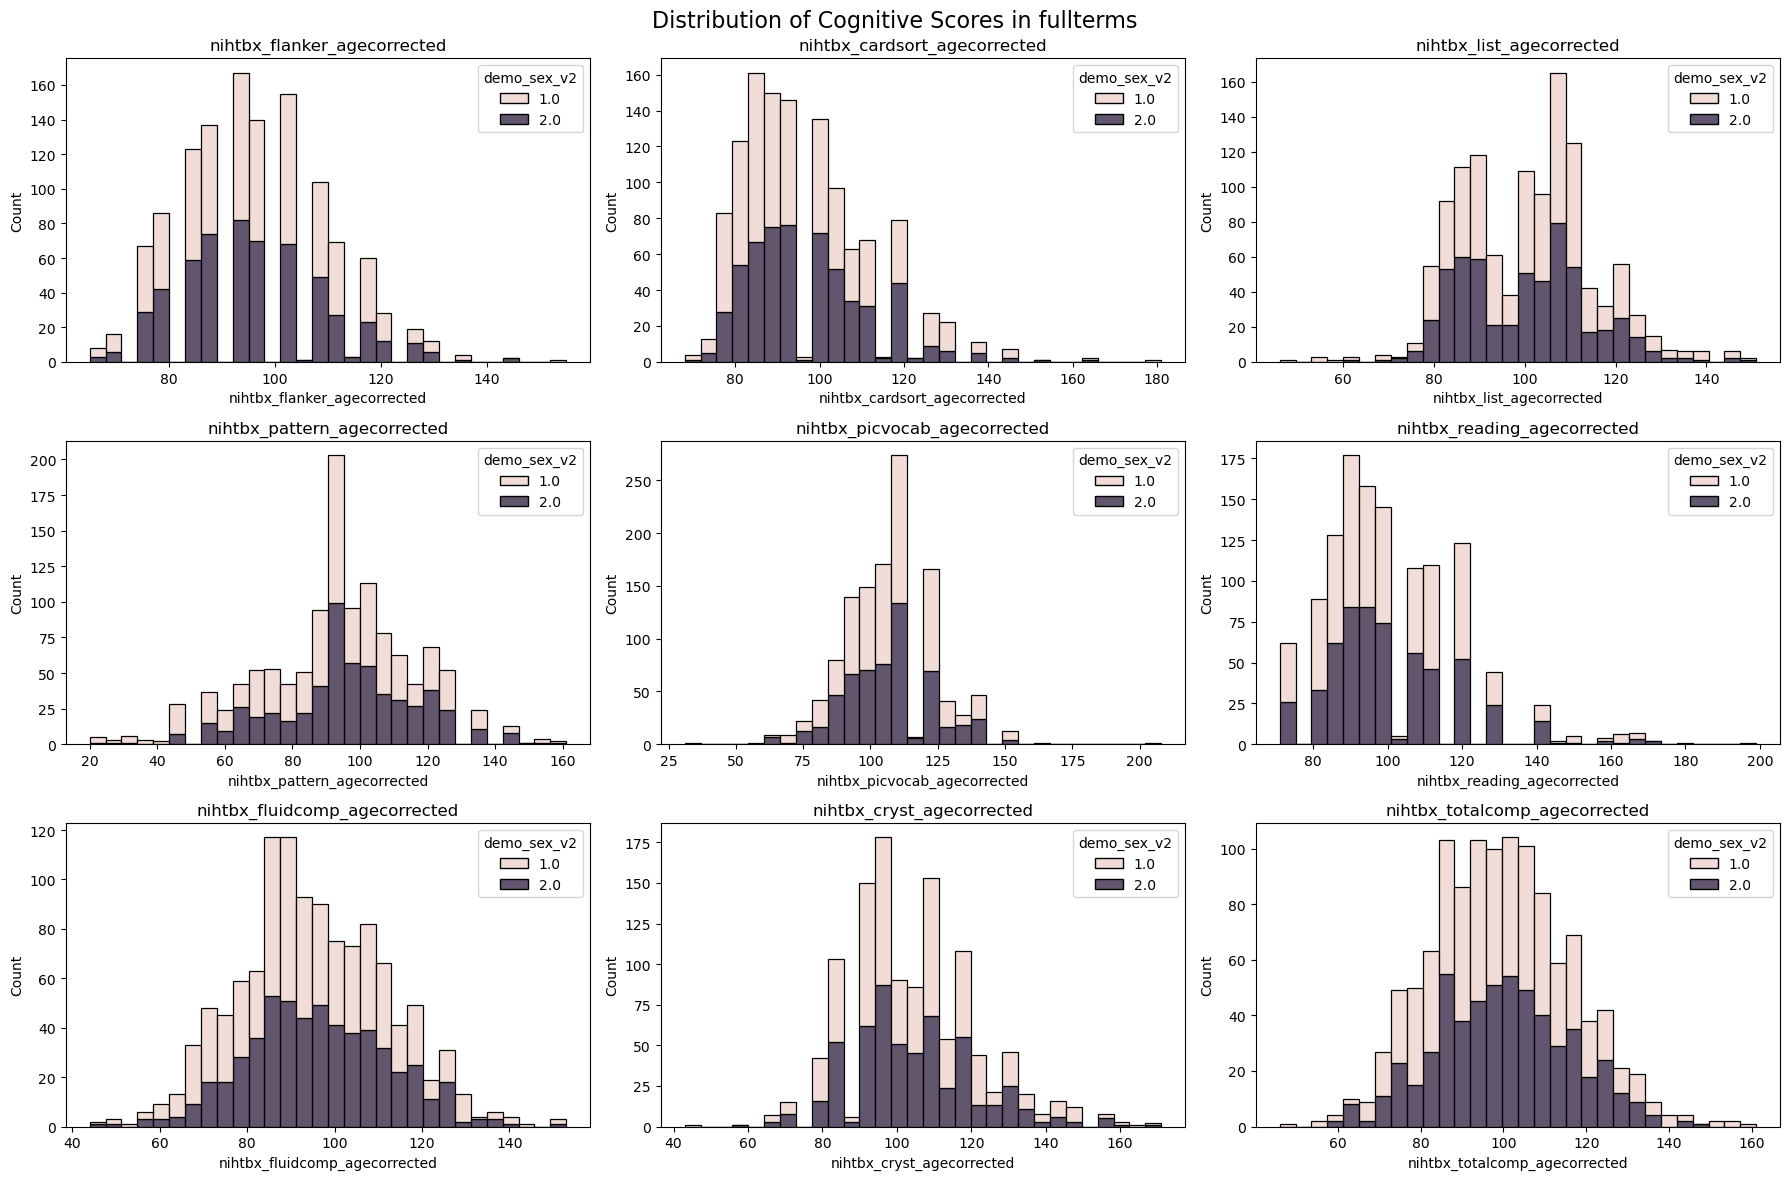

In [144]:
# histograms of each score by prematurity class
# a subplot for each score
import matplotlib.pyplot as plt
import seaborn as sns


#get the sex of the subjects from another dataframe
df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/df_with_cognition_and_ages.csv")
df_sex = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/all_labels_clean_abcd_new_classes.csv")[["src_subject_id_clean","demo_sex_v2"]]

df = df.merge(df_sex,left_on="src_subject_id",right_on="src_subject_id_clean",how="inner")

print(df.columns)


# sub_df for each prematurity class
df['prem_class'] = df['prem_class'].astype(str)
df_vpre = df[df['prem_class'] == '<28']

df_pre = df[df['prem_class'] == '28-32']


df_term = df[df['prem_class'] == '>=37']


df_smallpre = df[df['prem_class'] == '32-37']



plt.subplots_adjust(hspace=0.5, wspace=0.3)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
for i, score in enumerate(scores):
    ax = axes[i // 3, i % 3]
    sns.histplot(
        data=df_smallpre,
        x=score,
        hue="demo_sex_v2",
        multiple="stack",
        bins=30,
        ax=ax,
    )

    ax.set_title(score)
fig.suptitle("Distribution of Cognitive Scores in fullterms", fontsize=16)
plt.tight_layout()

plt.show()

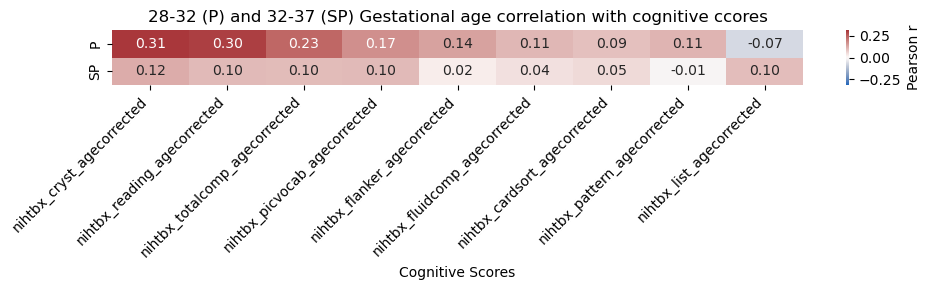

In [102]:
#  Charger le CSV
df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/csv/cognitive/prematurity_stats_simple.csv")

# Sécurité : indexer par score (chaque ligne = un test cognitif)
df = df.set_index('score')

# Option : listes de colonnes à utiliser
r_pre_col = 'pearson_r_ga_pre'
r_smallpre_col = 'pearson_r_ga_smallpre'
d_cohen_col = 'cohen_d_pre_vs_term'
p_pre_col = 'pearson_p_ga_pre'
p_smallpre_col = 'pearson_p_ga_smallpre'
p_t_col = 'p_t_pre_vs_term'

# Construire une petite DataFrame ligne = groupe (pre / smallpre), colonnes = scores
r_matrix = pd.DataFrame({
    'P': df[r_pre_col],
    'SP': df[r_smallpre_col]
}).T   # transpose pour que les groupes soient les lignes

order = r_matrix.mean().sort_values(ascending=False).index
r_matrix = r_matrix[order]

plt.figure(figsize=(10,3))
v = np.nanmax(np.abs(r_matrix.values))  # symétrie pour palette diverging
sns.heatmap(r_matrix, annot=True, fmt=".2f", cmap="vlag", center=0,
            vmin=-v, vmax=v, cbar_kws={'label':'Pearson r'})
plt.title("28-32 (P) and 32-37 (SP) Gestational age correlation with cognitive ccores")
plt.xlabel("Cognitive Scores")      
plt.ylabel("")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




/tmp/ipykernel_692329/290368584.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


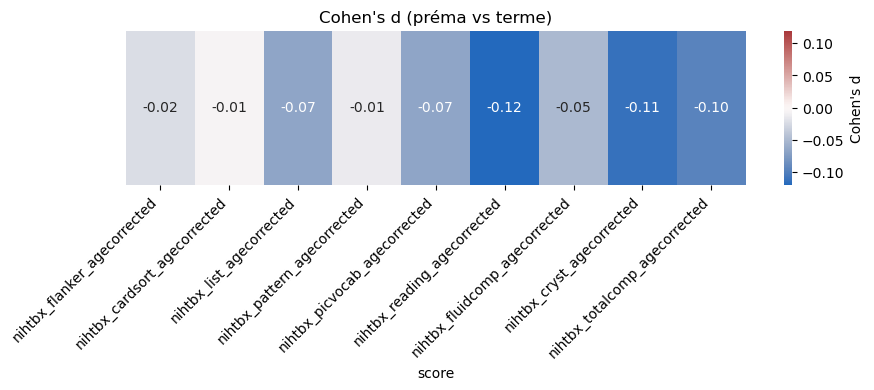

In [103]:
d_series = df[d_cohen_col]
d_df = d_series.to_frame().T  # 1 ligne

plt.figure(figsize=(10,2))
v = np.nanmax(np.abs(d_df.values))
sns.heatmap(d_df, annot=True, fmt=".2f", cmap="vlag", center=0, vmin=-v, vmax=v,
            cbar_kws={'label': "Cohen's d"})
plt.title("Cohen's d (préma vs terme)")
plt.xticks(rotation=45, ha='right')
plt.yticks([])  # cacher l'axe y si une seule ligne
plt.tight_layout()
plt.show()


In [151]:
df_cognition  = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/df_with_cognition_and_ages.csv")

df_cognition  = df_cognition[df_cognition['prem_class'].isin(["<28","28-32","32-37"])]  


scores = [
 'nihtbx_flanker_agecorrected',
 'nihtbx_cardsort_agecorrected',
 'nihtbx_list_agecorrected',
 'nihtbx_pattern_agecorrected',
 'nihtbx_picvocab_agecorrected',
 'nihtbx_reading_agecorrected',
 'nihtbx_fluidcomp_agecorrected',
 'nihtbx_cryst_agecorrected',
 'nihtbx_totalcomp_agecorrected'
]


ranked_ids = pd.DataFrame()

for score in scores:
    # On retire les sujets qui ont un NaN pour ce test
    tmp = df_cognition[["src_subject_id", score]].dropna()

    # On trie les IDs selon le score décroissant
    ranked_ids[score + "_ids"] = (
        tmp.sort_values(score, ascending=False)["src_subject_id"].reset_index(drop=True)
    )
    ranked_ids[score] = (
        tmp.sort_values(score, ascending=False)[score].reset_index(drop=True)
    )

# # Vérification
# print(ranked_ids.head())

# Sauvegarde
ranked_ids.to_csv(
    "/neurospin/dico/rmenasria/Runs/03_main/Output/csv/cognitive/ranked_ids_and_scores.csv",
    index=False
)

to_check = ["nihtbx_list_agecorrected_ids", "nihtbx_totalcomp_agecorrected_ids", "nihtbx_fluidcomp_agecorrected_ids"]

for score in to_check:
    tmp = ranked_ids[score].dropna()
    # Meilleurs 12
    top_12 = tmp.head(12).values

    # Pires 12
    bottom_12 = tmp.tail(12).values

    # Subject with an average score
    avg_12 = tmp.iloc[len(tmp)//2 - 6 : len(tmp)//2 + 6].values

    print(f"Sujets ayant les meilleurs scores pour le test {score} :")
    print(top_12)

    print(f"Sujets ayant les pires scores pour le test {score} :")
    print(bottom_12)

    print(f"Sujets ayant des scores moyens pour le test {score} :")
    print(avg_12)




Sujets ayant les meilleurs scores pour le test nihtbx_list_agecorrected_ids :
['NDARINVEMTG90C4' 'NDARINVJLXMB8LP' 'NDARINVL453XJAG' 'NDARINVJFNE6XKX'
 'NDARINV4HBVU8XK' 'NDARINVAGR3FFR1' 'NDARINVKWG00F0U' 'NDARINVMPPV8539'
 'NDARINVD3D1K2BX' 'NDARINV5MHT9RR4' 'NDARINVELK0KFTA' 'NDARINVHGEY0HNL']
Sujets ayant les pires scores pour le test nihtbx_list_agecorrected_ids :
['NDARINVVPL7432C' 'NDARINVLKGBPW16' 'NDARINVGEBV73N8' 'NDARINVXMJE5DN0'
 'NDARINVCUHZ4YBK' 'NDARINVF9XMG0N0' 'NDARINVTJ3UDA2V' 'NDARINVTM4YT5UD'
 'NDARINVYHJRWF2C' 'NDARINVB0ZML1XP' 'NDARINVRYT5RRUM' 'NDARINVFH4MDTK5']
Sujets ayant des scores moyens pour le test nihtbx_list_agecorrected_ids :
['NDARINV4P5P4UP1' 'NDARINV4R9BND6G' 'NDARINV4RW0XZTG' 'NDARINV34HCN2RW'
 'NDARINV26L6B73E' 'NDARINVF1E6TJJ9' 'NDARINV94N4B0N9' 'NDARINVX1M23RL5'
 'NDARINVXHPZ989Y' 'NDARINVLLRVRMM8' 'NDARINVLN9JCZ56' 'NDARINVLEND5NH4']
Sujets ayant les meilleurs scores pour le test nihtbx_totalcomp_agecorrected_ids :
['NDARINVHZFMKD7L' 'NDARINVYVB

In [156]:
# top, average and worst subjects for the picvocab test according to the classification direction 

df_classif_direc_picvocab = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/csv/cognitive/direction/direction_premas_nihtbx_picvocab_agecorrected_FColl-SRh_right.csv")

df_classif_direc_picvocab = df_classif_direc_picvocab.sort_values("y_pred",ascending=False)

top_16 = df_classif_direc_picvocab.head(16)["subject_id"].values
bottom_16 = df_classif_direc_picvocab.tail(16)["subject_id"].values
avg_16 = df_classif_direc_picvocab.iloc[len(df_classif_direc_picvocab)//2 - 8 : len(df_classif_direc_picvocab)//2 + 8]["subject_id"].values

# add the prefix "sub-" to each subject id
top_16 = ["sub-" + str(s) for s in top_16]
bottom_16 = ["sub-" + str(s) for s in bottom_16]
avg_16 = ["sub-" + str(s) for s in avg_16]

print("Top 16 subjects for the picvocab test according to the classification direction :")
print(top_16)
print("Bottom 16 subjects for the picvocab test according to the classification direction :")
print(bottom_16)
print("Average 16 subjects for the picvocab test according to the classification direction :")
print(avg_16)




Top 16 subjects for the picvocab test according to the classification direction :
['sub-NDARINVYFW72521', 'sub-NDARINVXBX1H8JJ', 'sub-NDARINVUFJX48LE', 'sub-NDARINVFLA7T3CM', 'sub-NDARINV3B60KLEU', 'sub-NDARINVEZXL2KXT', 'sub-NDARINVN18KZ8TG', 'sub-NDARINV898CW3V8', 'sub-NDARINVMWH0MZFX', 'sub-NDARINVXPGNE2W4', 'sub-NDARINVNMJZEZRD', 'sub-NDARINVFZ97ZA0Z', 'sub-NDARINVXXKJDH17', 'sub-NDARINVMBU1DVRD', 'sub-NDARINVRTYGC16L', 'sub-NDARINVGB26JEH6']
Bottom 16 subjects for the picvocab test according to the classification direction :
['sub-NDARINV4HUTD0B9', 'sub-NDARINV32GN03AZ', 'sub-NDARINVDYNUN0GN', 'sub-NDARINV6NR4NZWL', 'sub-NDARINVD3D1K2BX', 'sub-NDARINV5NNKMGJE', 'sub-NDARINVV5HEJ9PA', 'sub-NDARINVZWAPL39H', 'sub-NDARINVWT771AK6', 'sub-NDARINVXWDXTUZ0', 'sub-NDARINVMHC4X2ZU', 'sub-NDARINV8C5PMGAM', 'sub-NDARINV7239K1HB', 'sub-NDARINVLLGNHY2A', 'sub-NDARINVKLT2ZLDF', 'sub-NDARINVF9XMG0N0']
Average 16 subjects for the picvocab test according to the classification direction :
['sub-NDA

: 